In [196]:
import math
import numpy as np 
import matplotlib.pyplot as plt 
import random
%matplotlib inline


In [4]:
def f(x):
    return 3*x**2 - 4*x + 5


In [5]:
f(3.0)

20.0

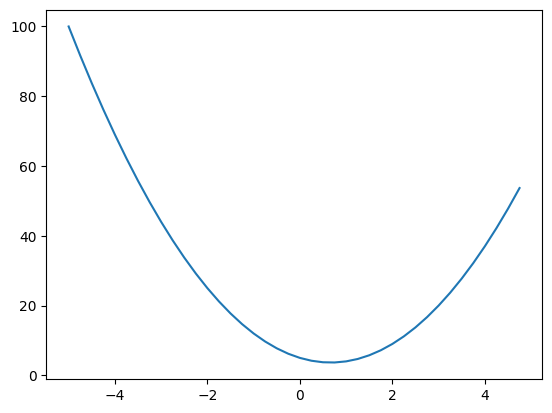

In [9]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)

plt.plot(xs, ys)

In [ ]:
# calculating the derivative of f(x)
# Instead of calulcating the derivative anallytically, we will approximate it instead
# Goes without saying that this will not work if the function is not differentiable at that point

h = 0.0000001 # as h tends to 0, we get a better approximation
x = 3.0

(f(x + h) - f(x)) / h


0.0

In [15]:
# function in 3 variables 
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [ ]:
# Now we will calculate the partial derivatives of d with respect to a, b and c

h = 0.0001

# fix the inputs
a = 2.0
b = -3.0
c = 10.0


# varying a
d1  = a*b + c
a+=h
d2 = a*b + c

print('d1', d1)
print('d2', d2) 
print('slope', (d2 - d1) / h)  # partial derivative of d with respect to a. 
                            # intuitively, this will be negative, given b is fixed

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [188]:
class Value:
    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self.grad = 0.0 
        self._backward = lambda : None # By default does nothing, holds true for leaf nodes
        self._prev = set(_children) # this is to maintain the computational graph
        self._op = _op
        self.label = label

    def __repr__(self): #  __repr__ function defines the "official" string representation of an object. This representation is primarily intended for developers and is used for debugging and introspection.
        return f"Value(data={self.data})"
    
    def __add__(self, other): # This will be called internally if we do a + b where a and b are instances of Value class
        other = other if isinstance(other, Value) else Value(other)
        out =  Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other -1)) * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

        
    
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a * b; e.label = 'e'

d= e + c #internally calls (a.__mul__(b)).__add__(c) method
d.label = 'd'

f = Value(-2.0, label = 'f')

L = d*f; L.label = 'L'


In [163]:
# we use graphviz to visualize the computational graph

from graphviz import Digraph

def trace(root):
    # build a set of all nodes and edges in the graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr={'rankdir':'LR'}) # LR means left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))

        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label  = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad) , shape = 'record')

        if n._op:
            # if the value is a result of some operation, create a node for the operation
            dot.node(name = uid + n._op, label = n._op)
            # and connect the operation node to the value node
            dot.edge(uid + n._op, uid)
        
    for n1, n2 in edges:
        # connect n1 to the output node of n2
        dot.edge(str(id(n1)), str(id(n2))+n2._op)
    
    return dot



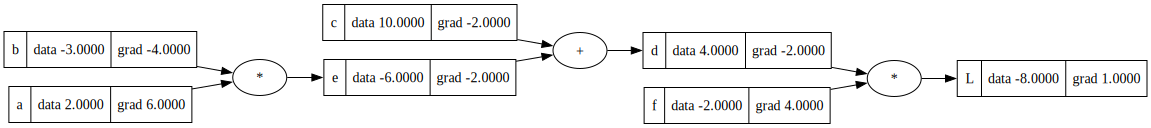

In [ ]:
draw_dot(L)

In [165]:
L.grad = 1.0
d.grad = f.data
f.grad = d.data
e.grad = d.grad 
c.grad = d.grad
a.grad = b.data * e.grad
b.grad = a.data * e.grad



In [144]:
# We can use the chain rule to compute the gradients
# For example, dL/dc = (dL/dd) * (dd/dc)

a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * d.grad

e = a*b
d = e+c
L = d*f

L.data

-7.509552

In [167]:
# function to see how the output is affected by small changes in inputs, basically DL/dx for each input variable

def lol():

    h = 0.0001

    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a * b; e.label = 'e'
    d= e + c #internally calls (a.__mul__(b)).__add__(c) method
    d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d*f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a * b; e.label = 'e'
    e.data +=h
    d= e + c #internally calls (a.__mul__(b)).__add__(c) method
    d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d*f; L.label = 'L'
    L2 = L.data

    print((L2 - L1) / h)

lol()

-1.9999999999953388


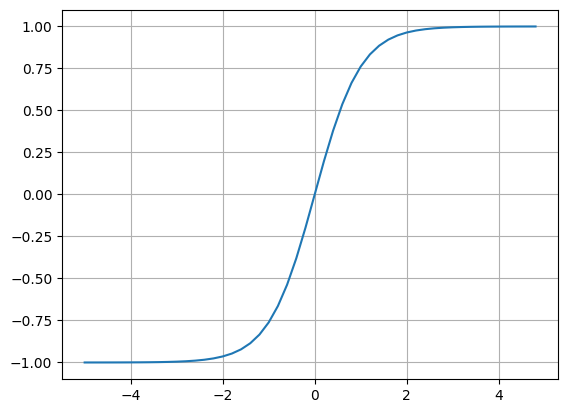

In [168]:
# backpropogations trough a neuron

# plotting the tanh function

plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid()

In [176]:
# Creating a neuron with 2 inputs

x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

# weights w1, w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

# bias of the neuron
b = Value(6.8813735870195432, label = 'b')

# outut of the neuron before activation
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'



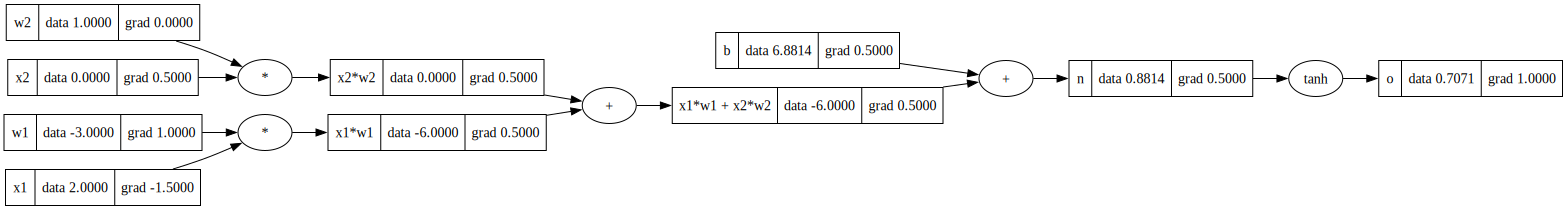

In [179]:
draw_dot(o)

In [149]:
o.grad = 1.0
o._backward()
n._backward()
b._backward() # no result since b is a leaf node
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

In [172]:
# topological sort: It is a reordering of the nodes in a directed acyclic graph such that for every directed edge from node A to node B, node A appears before node B in the ordering.

# implementation of topological sort
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [173]:
o.grad = 1.0
for node in reversed(topo):
    node._backward()

In [178]:
# adding it to the class itself and then checking
o.backward()

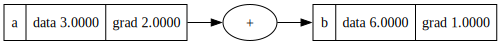

In [180]:
# there is a bug here, if we add the same variable twice then we get the wrong output
a = Value(3.0, label = 'a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

# gradient is wrong here

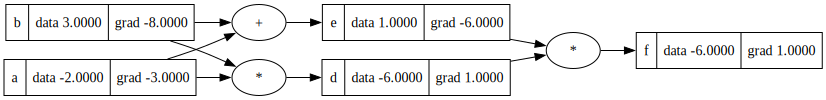

In [ ]:
# another issue is multiple edges coming from the same node
a = Value(-2.0, label = 'a')
b= Value(3.0, label = 'b')
d = a *b; d.label = 'd'
e = a + b ; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()

draw_dot(f)

# Basically anytime we use the same variable multiple times, the gradients are not accumulating

# we fix this by accumulating the gradients in the _backward function itself

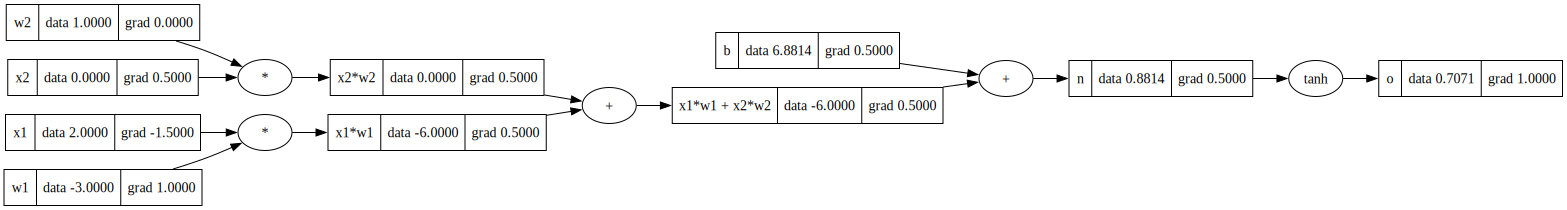

In [ ]:
# coming back to our neuron example

# Creating a neuron with 2 inputs.

x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

# weights w1, w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

# bias of the neuron
b = Value(6.8813735870195432, label = 'b')

# outut of the neuron before activation
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

o.backward()
draw_dot(o)


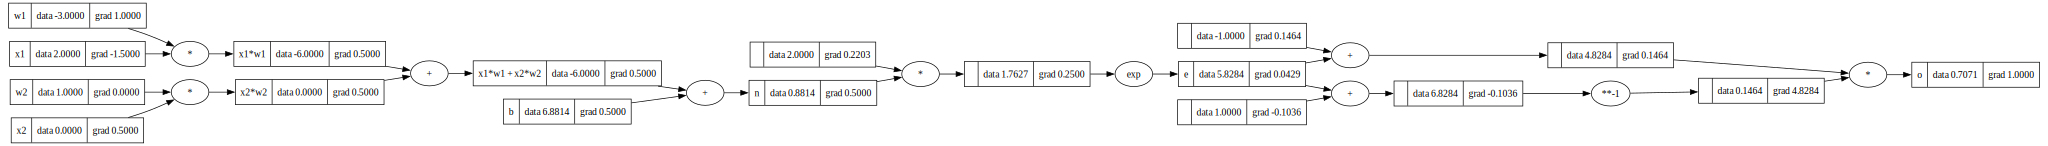

In [193]:
# We will break up tanh into its components

x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

# weights w1, w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

# bias of the neuron
b = Value(6.8813735870195432, label = 'b')

# outut of the neuron before activation
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# ----

e = (2*n).exp(); e.label = 'e'
o = (e -1) / (e +1); o.label = 'o'

#----

o.backward()
draw_dot(o)


In [ ]:
# same thing in pytorch

import torch

# Everything is based on tensors (n-dimensional arrays of scalara)
x1 = torch.tensor([2.0]).double(); x1.requires_grad = True # double means 64 bit float, same as float in micrograd
x2 = torch.tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.tensor([1.0]).double(); w2.requires_grad = True
b = torch.tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('w1', w1.grad.item())
print('x1', x1.grad.item())


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
w1 1.0000002567688737
x1 -1.5000003851533106


In [273]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):  # this is called in the format class_instance(x)
        # w * x + b
        act =  sum((wi* xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [ Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [ n(x) for n in self.neurons]
        return outs[0] if len(outs) ==1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [ Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]



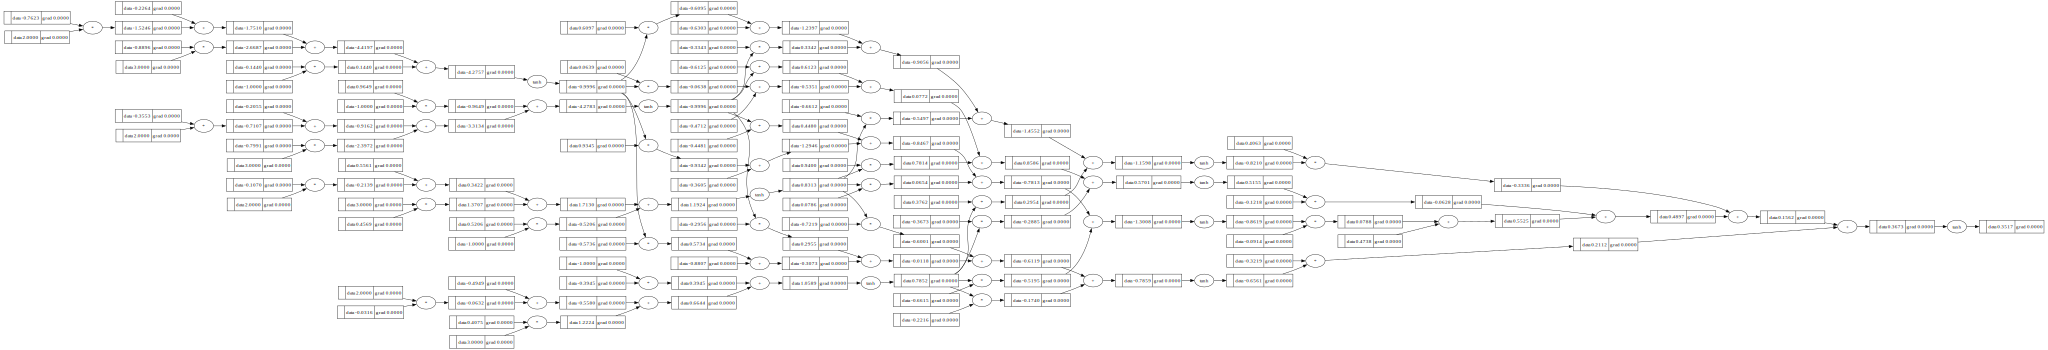

In [280]:
n = MLP(3, [4,4,1])
draw_dot(n(x))

In [281]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] # expected outputs


In [271]:
# Loss: A number which represents how well or poorly our model is performing. We try to minimize the loss
# one kind of loss is mean squared error
ypred = [n(x) for x in xs]

loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), start = Value(0))


In [259]:
loss.backward()

In [ ]:
# We need to aggregate all the parameters of the model so that we can update them during training
for p in n.parameters():
    p.data += -0.01 * p.grad # gradient descent step
    # After this, the loss should ideally reduce
    

In [282]:
for k in range(20):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), start = Value(0))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0 # reset gradients to zero before next backward pass
    loss.backward()


    # update parameters
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 4.1027929424249505
1 3.4917032399750765
2 3.15273903320735
3 2.717828813025703
4 2.12837645878616
5 1.4307273843858355
6 0.8582539763468804
7 0.5340228140285581
8 0.364676400759862
9 0.26861813440487864
10 0.2089006308902683
11 0.16898525360941136
12 0.14078411948049757
13 0.11998280374879211
14 0.1041069840722316
15 0.09165130865253002
16 0.0816544319467226
17 0.07347716487556194
18 0.06667984109382677
19 0.06095115852215872


In [283]:
ypred # will be close to ys now

[Value(data=0.9202387874608913),
 Value(data=-0.8764252472180266),
 Value(data=-0.8490876236475996),
 Value(data=0.8713763527379376)]